# <span style="color:#0b486b">  FIT3181: Deep Learning (2021)</span>
***
*CE/Lecturer:*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Head TA:*  **Mr Thanh Nguyen** | thanh.nguyen4@monash.edu <br/>
*Tutor:* **Dr Van Nguyen**  \[van.nguyen1@monash.edu \] | **Mr James Tong** \[james.tong1@monash.edu\] | **Dr Mahmoud Mohammad** \[mahmoud.hossam@monash.edu\]
<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***


# <span style="color:#0b486b">Tutorial 7b: Attack and Defence Deep Learning Models</span>  <span style="color:red">*****</span> # 
This is a **have-to-learn** knowledge because this would appear in the exam or assignment of this unit. 

**Deep learning models even the SOTA ones are fragile and easy to be attacked by adversarial examples. This tutorial focuses on how to run attacks to fool deep learning models and how to train more secure and safe deep learning models using adversarial training:**

I. Adversarial attacks including FGSM, PGD and TRADES.

II. Train more secure and robust models using adversarial training.

**References and additional reading and resources**
- Adversarial machine learning tutorial ([link](https://adversarial-ml-tutorial.org/introduction/)).
- Adversarial example using FGSM tutorial ([link](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm)).
---


## <span style="color:#0b486b">I. Define attack functions </span> ##

We first manually implement the popular adversarial attacks including FGSM, PGD, MIM, and TRADES ones. Those attacks have also been implemented in [CleverHans](https://github.com/cleverhans-lab/cleverhans), a library for adversarial machine learning in which many adversarial attacks are implemented. Subsequently, we can use those adversarial examples crafted from those attacks to strengthen the adversarial robustness of DL models for obtaining more robust and secure DL models.

In [1]:
import tensorflow as tf 

We first implement Fast Gradient Sign Method (FGSM) in this paper: https://arxiv.org/pdf/1412.6572.pdf.

In [2]:
def fgsm_attack(model, input_image, input_label=None, 
               epsilon=0.3, 
               clip_value_min=0., 
               clip_value_max=1.0, 
               soft_label=False,
               from_logits=True): 
    """
    Args: 
        model: pretrained model 
        input_image: original (clean) input image (tensor)
        input_label: original label (tensor, categorical representation)
        epsilon: perturbation boundary 
        clip_value_min, clip_value_max: range of valid input 
        from_logits = True: attack from logits otherwise attack from prediction probabilites
    Note: 
        we expect the output of model should be logits vector 
    """
    
    loss_fn = tf.keras.losses.sparse_categorical_crossentropy # compute CE loss from logits or prediction probabilities
    
    if type(input_image) is np.ndarray: 
        input_image = tf.convert_to_tensor(input_image)
    
    if type(input_label) is np.ndarray: 
        input_label = tf.convert_to_tensor(input_label)
        
    with tf.GradientTape() as tape: 
        tape.watch(input_image)
        output = model(input_image)
        if not soft_label:
            loss = loss_fn(input_label, output, from_logits=from_logits) # use ground-truth label to attack
        else: 
            pred_label = tf.math.argmax(output, axis=1) # use predicted label to attack
            loss = loss_fn(pred_label, output, from_logits=from_logits)

    gradient = tape.gradient(loss, input_image) # get the gradients of the loss w.r.t. the input image 
    adv_image = input_image + epsilon * tf.sign(gradient) # get the final adversarial examples 
    adv_image = tf.clip_by_value(adv_image, clip_value_min, clip_value_max) # clip to a valid range  
    adv_image = tf.stop_gradient(adv_image) # stop the gradient to make the adversarial image as a constant input
    return adv_image

We now implement  Projected Gradient Descend (PGD) proposed in this paper: https://openreview.net/pdf?id=rJzIBfZAb. PGD can be viewed as an extended version of FGSM in which we attack in many iterations.

In [3]:
def pgd_attack(model, input_image, input_label= None, 
              epsilon=0.3, 
              num_steps=20, 
              step_size=0.01, 
              clip_value_min=0., 
              clip_value_max=1.0, 
              soft_label=False,
              from_logits= True): 
    """
    Args: 
        model: pretrained model 
        input_image: original (clean) input image (tensor)
        input_label: original label (tensor, categorical representation)
        epsilon: perturbation boundary 
        num_steps: number of attack steps 
        step_size: size of each move in each attack step 
        clip_value_min, clip_value_max: range of valid input 
        from_logits = True: attack from logits otherwise attack from prediction probabilites
    Note: 
        we expect the output of model should be logits vector  
    """       
    
    loss_fn = tf.keras.losses.sparse_categorical_crossentropy  #compute CE loss from logits or prediction probabilities
    
    if type(input_image) is np.ndarray: 
        input_image = tf.convert_to_tensor(input_image)
    
    if type(input_label) is np.ndarray: 
        input_label = tf.convert_to_tensor(input_label)
        
    # random initialization around input_image 
    random_noise = tf.random.uniform(shape=input_image.shape, minval=-epsilon, maxval=epsilon)
    adv_image = input_image + random_noise

    for _ in range(num_steps): 
        with tf.GradientTape(watch_accessed_variables=False) as tape: 
            tape.watch(adv_image)
            adv_output = model(adv_image)
            if not soft_label:
                loss = loss_fn(input_label, adv_output, from_logits= from_logits) # use ground-truth label to attack
            else: 
                pred_label = tf.math.argmax(adv_output, axis=1)
                loss = loss_fn(pred_label, adv_output, from_logits= from_logits) # use predicted label to attack

        gradient = tape.gradient(loss, adv_image) # get the gradient of the loss w.r.t. the current point 
        adv_image = adv_image + step_size * tf.sign(gradient) # move current adverarial example along the gradient direction with step size is eta 
        adv_image = tf.clip_by_value(adv_image, input_image-epsilon, input_image+epsilon) # clip to a valid boundary  
        adv_image = tf.clip_by_value(adv_image, clip_value_min, clip_value_max)  # clip to a valid range
        adv_image = tf.stop_gradient(adv_image) # stop the gradient to make the adversarial image as a constant input 
    return adv_image

We now implement Momentum Iterative Method (MIM) proposed in this paper: https://openaccess.thecvf.com/content_cvpr_2018/papers/Dong_Boosting_Adversarial_Attacks_CVPR_2018_paper.pdf. MIM uses a momentum approach to boost the adversarial examples.

In [4]:
def mim_attack(model, input_image, input_label= None, 
              epsilon=0.3, 
              gamma= 0.9,
              num_steps=20, 
              step_size=0.01, 
              clip_value_min=0., 
              clip_value_max=1.0, 
              soft_label=False,
              from_logits= True): 
    """
    Args: 
        model: pretrained model 
        input_image: original (clean) input image (tensor)
        input_label: original label (tensor, categorical representation)
        epsilon: perturbation boundary 
        gamma: momentum decay
        num_steps: number of attack steps 
        step_size: size of each move in each attack step 
        clip_value_min, clip_value_max: range of valid input 
        from_logits = True: attack from logits otherwise attack from prediction probabilites
    Note: 
        we expect the output of model should be logits vector  
    """       
    
    loss_fn = tf.keras.losses.sparse_categorical_crossentropy # compute CE loss from logits or prediction probabilities
    
    if type(input_image) is np.ndarray: 
        input_image = tf.convert_to_tensor(input_image)
    
    if type(input_label) is np.ndarray: 
        input_label = tf.convert_to_tensor(input_label)
        
    # random initialization around input_image 
    random_noise = tf.random.uniform(shape=input_image.shape, minval=-epsilon, maxval=epsilon)
    adv_image = input_image + random_noise
    adv_noise = random_noise

    for _ in range(num_steps): 
        with tf.GradientTape(watch_accessed_variables=False) as tape: 
            tape.watch(adv_image)
            adv_output = model(adv_image)
            if not soft_label:
                loss = loss_fn(input_label, adv_output, from_logits=from_logits) # use ground-truth label to attack
            else: 
                pred_label = tf.math.argmax(adv_output, axis=1)
                loss = loss_fn(pred_label, adv_output, from_logits=from_logits) # use predicted label to attack

        gradient = tape.gradient(loss, adv_image) # get the gradient of the loss w.r.t. the current point 
        adv_image_new = adv_image + step_size * tf.sign(gradient) # move current adverarial example along the gradient direction with step size is eta 
        adv_image_new = tf.clip_by_value(adv_image_new, input_image-epsilon, input_image+epsilon) # clip to a valid boundary  
        adv_image_new = tf.clip_by_value(adv_image_new, clip_value_min, clip_value_max) # clip to a valid range
        adv_noise = gamma*adv_noise + (1-gamma)*(adv_image_new - adv_image)
        adv_image = adv_image_new
        adv_image = tf.stop_gradient(adv_image) # stop the gradient to make the adversarial image as a constant input 
    adv_image = adv_image + adv_noise
    adv_image = tf.clip_by_value(adv_image, input_image-epsilon, input_image+epsilon) # clip to a valid boundary  
    adv_image = tf.clip_by_value(adv_image, clip_value_min, clip_value_max) # clip to a valid range
    return adv_image

Finally, we implement one of the most famous approaches for attack and defence TRADES proposed in this paper: http://proceedings.mlr.press/v97/zhang19p/zhang19p.pdf.

In [5]:
def trades_attack(model, input_image, input_label, 
                 epsilon=0.3, 
                  num_steps=20, 
                  step_size=0.01, 
                  clip_value_min=0., 
                  clip_value_max=1.0,
                  from_logits= False): 
    """
    Args: 
        model: pretrained model 
        input_image: original (clean) input image (tensor)
        input_label: original label (tensor, categorical representation)
        epsilon: perturbation boundary 
        num_steps: number of attack steps 
        step_size: size of each move in each attack step 
        clip_value_min, clip_value_max: range of valid input
        from_logits = True: attack from logits otherwise attack from prediction probabilites
    Note: 
        we expect the output of model should be logits vector
    """      
    
    if type(input_image) is np.ndarray: 
        input_image = tf.convert_to_tensor(input_image)
    if type(input_label) is np.ndarray: 
        input_label = tf.convert_to_tensor(input_label)
        
    # random initialization around input_image 
    random_noise = tf.random.uniform(shape=input_image.shape, minval=-epsilon, maxval=epsilon)
    adv_image = input_image + random_noise

    nat_output = model(input_image)
    nat_prediction = nat_output if not from_logits else tf.math.softmax(nat_output, axis=1)

    for _ in range(num_steps): 
        with tf.GradientTape() as tape: 
            tape.watch(adv_image)
            adv_output = model(adv_image)
            adv_prediction = adv_output if not from_logits else tf.math.softmax(adv_output, axis=1)
            loss = tf.keras.losses.KLDivergence()(adv_prediction,  nat_prediction) 
        gradient = tape.gradient(loss, adv_image) # get the gradient of the loss w.r.t. the current point
        adv_image = adv_image + step_size * tf.sign(gradient) # move current adverarial example along the gradient direction with step size is eta  
        adv_image = tf.clip_by_value(adv_image, input_image-epsilon, input_image+epsilon) # clip to a valid boundary 
        adv_image = tf.clip_by_value(adv_image, clip_value_min, clip_value_max) # clip to a valid range
        adv_image = tf.stop_gradient(adv_image)  # stop the gradient to make the adversarial image as a constant input 
    return adv_image        

## <span style="color:#0b486b">II. Attack SOTA pretrained model</span> ##

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, models, layers
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.applications import VGG19
import math
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
import numpy as np

In [7]:
print("Loading network...")
vgg19 = VGG19(weights="imagenet", include_top=True, input_tensor=layers.Input(shape=(224,224,3)))
print("Showing layers...")
# loop over the layers in the network and display them to the console
for (i, layer) in enumerate(vgg19.layers):
    print("{}\t{}\t{}".format(i, layer.__class__.__name__, layer.name))

Loading network...
574717952/574710816 [==============================] - 495s 1us/step
Showing layers...
0	InputLayer	input_1
1	Conv2D	block1_conv1
2	Conv2D	block1_conv2
3	MaxPooling2D	block1_pool
4	Conv2D	block2_conv1
5	Conv2D	block2_conv2
6	MaxPooling2D	block2_pool
7	Conv2D	block3_conv1
8	Conv2D	block3_conv2
9	Conv2D	block3_conv3
10	Conv2D	block3_conv4
11	MaxPooling2D	block3_pool
12	Conv2D	block4_conv1
13	Conv2D	block4_conv2
14	Conv2D	block4_conv3
15	Conv2D	block4_conv4
16	MaxPooling2D	block4_pool
17	Conv2D	block5_conv1
18	Conv2D	block5_conv2
19	Conv2D	block5_conv3
20	Conv2D	block5_conv4
21	MaxPooling2D	block5_pool
22	Flatten	flatten
23	Dense	fc1
24	Dense	fc2
25	Dense	predictions


40960/35363 [==================================] - 0s 1us/step
Predicted: [('n02504458', 'African_elephant', 0.46538296), ('n02504013', 'Indian_elephant', 0.296702), ('n01871265', 'tusker', 0.23417)]


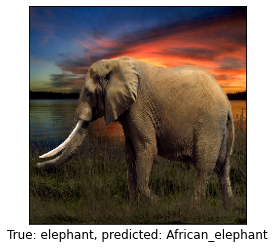

In [8]:
# img_path = './imgs/cat.jpg'
# img_path = './imgs/spider.jpg'
# img_path = './imgs/chicken.jpeg'
img_path = './imgs/elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
preds = vgg19.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])
plt.imshow(img)
plt.xlabel("True: elephant, predicted: {}".format(decode_predictions(preds, top=3)[0][0][1]), fontsize= 12)
plt.xticks([])
plt.yticks([])
plt.grid(False)

In [9]:
# soft_label=True so we do not need to provide input label
x_pgd= pgd_attack(vgg19, x, None, epsilon=8, num_steps=20,  step_size= 0.1, soft_label=True, clip_value_min=0.0, clip_value_max=255.0, from_logits=False)
pgd_pred = vgg19.predict(x_pgd)
true_label= decode_predictions(preds, top=3)[0][0][1]
adv_label= decode_predictions(pgd_pred, top=3)[0][0][1] 
print("True label: {}, adversarial label: {}".format(true_label, adv_label))

True label: African_elephant, adversarial label: Weimaraner


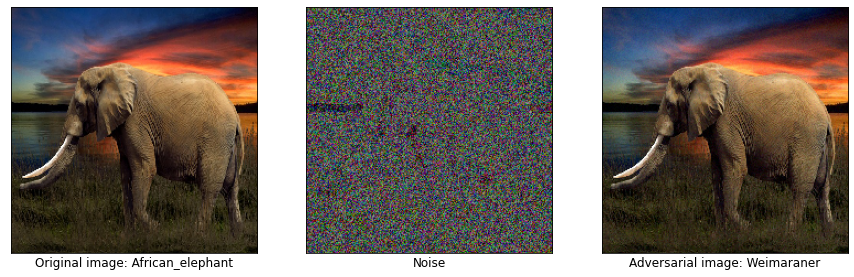

In [10]:
img_pgd = np.squeeze(x_pgd.numpy()).astype('int')
img = np.squeeze(x).astype('int')
noise_pgd = np.clip(np.abs(img_pgd - img)*20, 0, 255).astype('int') # we multiply the noise by 20 for visualization
fig = plt.figure(figsize=(15, 15*3))
for i in range(3):
    shown_img = img if i==0 else noise_pgd if i==1 else img_pgd
    shown_label = 'Original image: {}'.format(true_label) if i==0 else 'Noise' if i==1 else 'Adversarial image: {}'.format(adv_label)
    plt.subplot(1,3,i+1)
    plt.imshow(shown_img)
    plt.xlabel(shown_label, fontsize= 12)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

As you can observe, the adversarial image looks identical to the original one from human perception. We can uncomment other statements for loading other images to see more attacks.

## <span style="color:#0b486b">III. Attack and Defence Deep Learning Models</span> ##

### <span style="color:#0b486b">III.1 AlexNet/LeNet for MNIST classification</span> ###

In [11]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Sequential
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

Below we implement AlexNet for working with MNIST dataset. Note that we apply softmax activation at the output layer, hence the model returns the logits. 

In [12]:
def alex_net():
    alex_model = Sequential()
    alex_model.add(Conv2D(filters=96, input_shape=(28,28,1), kernel_size=(11,11), strides=(4,4), padding='same', activation='relu'))
    alex_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    alex_model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='same', activation='relu'))
    alex_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    alex_model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    alex_model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    alex_model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    alex_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    # Passing it to a Fully Connected layer
    alex_model.add(Flatten())
    # 1st Fully Connected Layer
    alex_model.add(Dense(4096, activation='relu'))
    alex_model.add(Dropout(0.4))
    # 2nd Fully Connected Layer
    alex_model.add(Dense(4096, activation='relu'))
    alex_model.add(Dropout(0.4))
    # 3rd Fully Connected Layer
    alex_model.add(Dense(1000, activation='relu'))
    alex_model.add(Dropout(0.4))
    # Output Layer
    alex_model.add(Dense(10, activation=None))  #only return logits without applying softmax
    return alex_model

In [13]:
alex_net = alex_net()
alex_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 7, 7, 96)          11712     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 256)         2973952   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 384)         885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 384)         1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 256)         8

Below we implement LeNet for working with MNIST dataset. Note that we do not apply softmax activation at the output layer, hence the model returns the logits. 

In [14]:
def le_net():
    model = Sequential()
    model.add(Conv2D(filters=6, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(28,28,1)))
    model.add(AveragePooling2D())
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(AveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=10, activation= None))   #only return logits without applying softmax
    return model

In [15]:
lenet = le_net()
lenet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 6)         60        
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 16)        880       
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               94200     
_________________________________________________________________
dense_5 (Dense)              (None, 84)               

### <span style="color:#0b486b">III.2 Create TensorFlow dataset for MNIST</span> ###

In [16]:
import tensorflow_datasets as tfds

In [17]:
 def convert_types(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

In [18]:
def ld_mnist(batch_size=64):
    dataset, info = tfds.load('mnist', data_dir='./datasets', with_info=True, as_supervised=True)
    mnist_train, mnist_test = dataset['train'], dataset['test']
    mnist_train = mnist_train.map(convert_types).shuffle(60000).batch(batch_size)
    mnist_test = mnist_test.map(convert_types).batch(batch_size)
    return {'train':mnist_train, 'test':mnist_test}

In [19]:
def plot_image_grid(num_row, num_col, image, label, image_shape):
        fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
        for i in range(num_row*num_col):
            ax = axes[i//num_col, i%num_col]
            ax.imshow(image[i].reshape(image_shape), cmap='gray')
            ax.set_title('Label: {}'.format(label[i]))
        plt.tight_layout()
        plt.show()

In [20]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR) # ignore the warnings

nb_classes = 10
samples_per_class = 10
total_samples = nb_classes * samples_per_class
for image, label in tfds.as_numpy(ld_mnist(1024)['train'].take(1)):  
    image_samples = np.zeros([total_samples, 28, 28, 1], dtype=image.dtype)
    label_samples = np.zeros((total_samples,), dtype=label.dtype)
    rng = np.random.RandomState()
    for i in range(nb_classes):
        yi_indices = np.where(label ==  i)[0]
        rng.shuffle(yi_indices)
        image_samples[samples_per_class * i:(i + 1) * samples_per_class, ...] = image[yi_indices[:samples_per_class]]
        label_samples[samples_per_class * i:(i + 1) * samples_per_class] = i

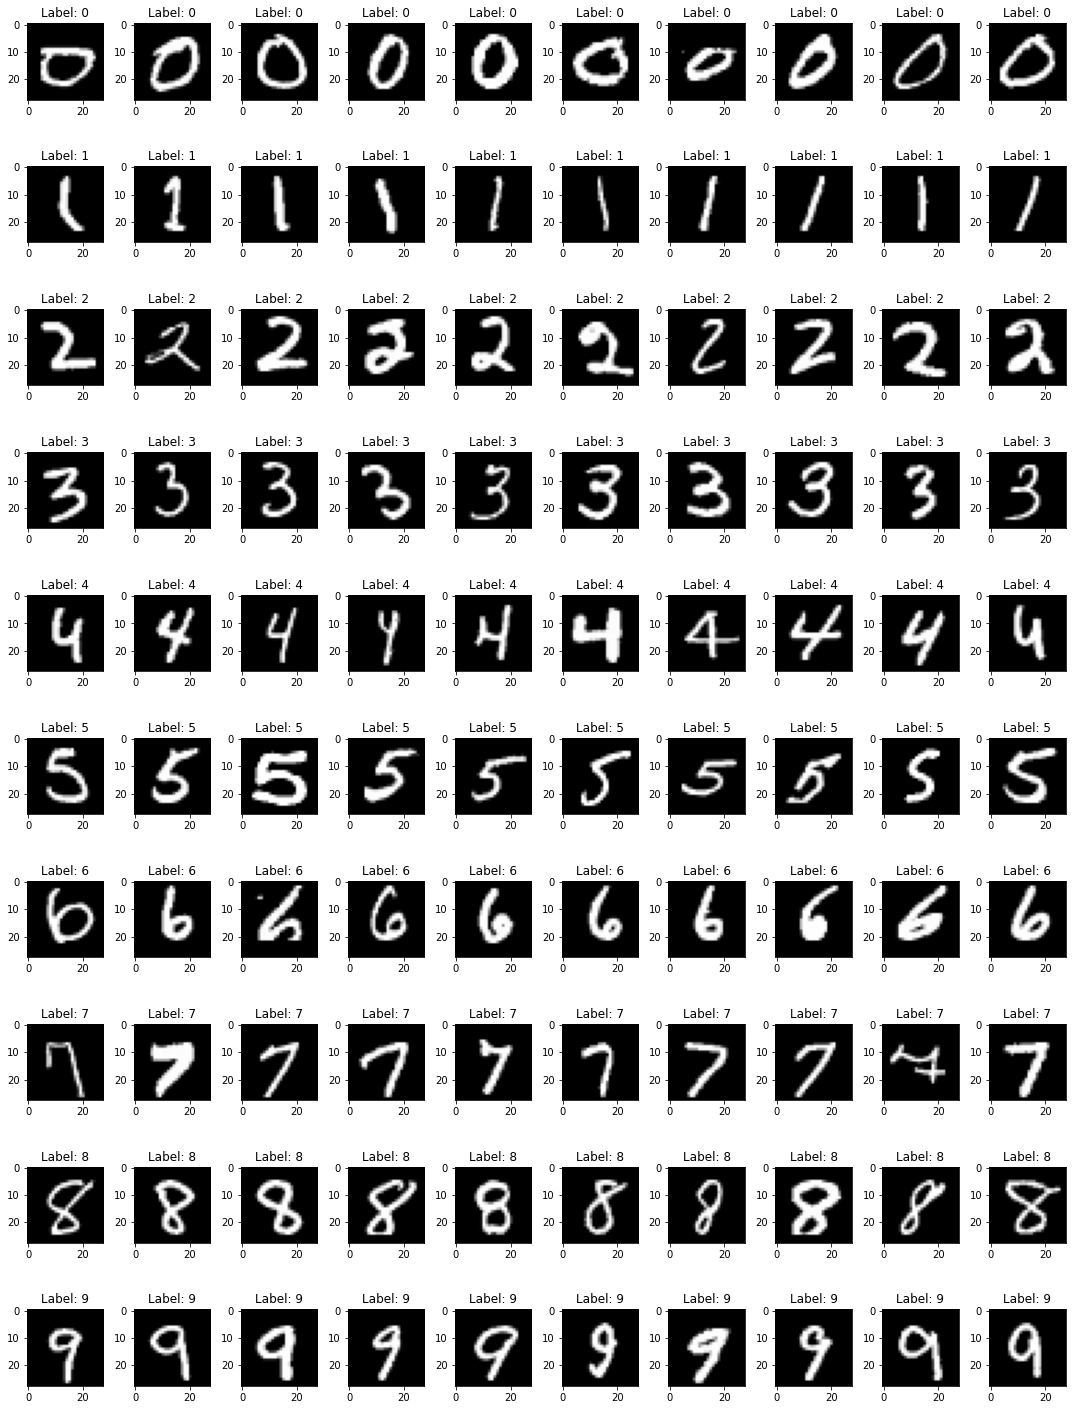

In [21]:
plot_image_grid(nb_classes, samples_per_class, image_samples, label_samples, (28, 28))

### <span style="color:#0b486b">III.3 Attack LeNet trained on MNIST without Adversarial Learning</span> ###

In [22]:
mnist_train = ld_mnist()['train']
mnist_test = ld_mnist()['test']

In [23]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
lenet.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
lenet.fit(mnist_train, epochs=5, validation_data=mnist_test)

Epoch 1/5
938/938 [==============================] - 7s 7ms/step - loss: 0.2720 - accuracy: 0.9194 - val_loss: 0.0871 - val_accuracy: 0.9708
Epoch 2/5
938/938 [==============================] - 7s 7ms/step - loss: 0.0828 - accuracy: 0.9747 - val_loss: 0.0799 - val_accuracy: 0.9737
Epoch 3/5
938/938 [==============================] - 7s 7ms/step - loss: 0.0595 - accuracy: 0.9818 - val_loss: 0.0456 - val_accuracy: 0.9848
Epoch 4/5
938/938 [==============================] - 7s 7ms/step - loss: 0.0474 - accuracy: 0.9855 - val_loss: 0.0426 - val_accuracy: 0.9868
Epoch 5/5
938/938 [==============================] - 7s 7ms/step - loss: 0.0373 - accuracy: 0.9883 - val_loss: 0.0382 - val_accuracy: 0.9885


We run an attack with PGD.

In [24]:
image_samples_adv = pgd_attack(lenet, image_samples, label_samples, 0.3, 20, 0.01, 0.0, 1.0)
label_sample_adv = np.argmax(lenet(image_samples_adv).numpy(), 1)

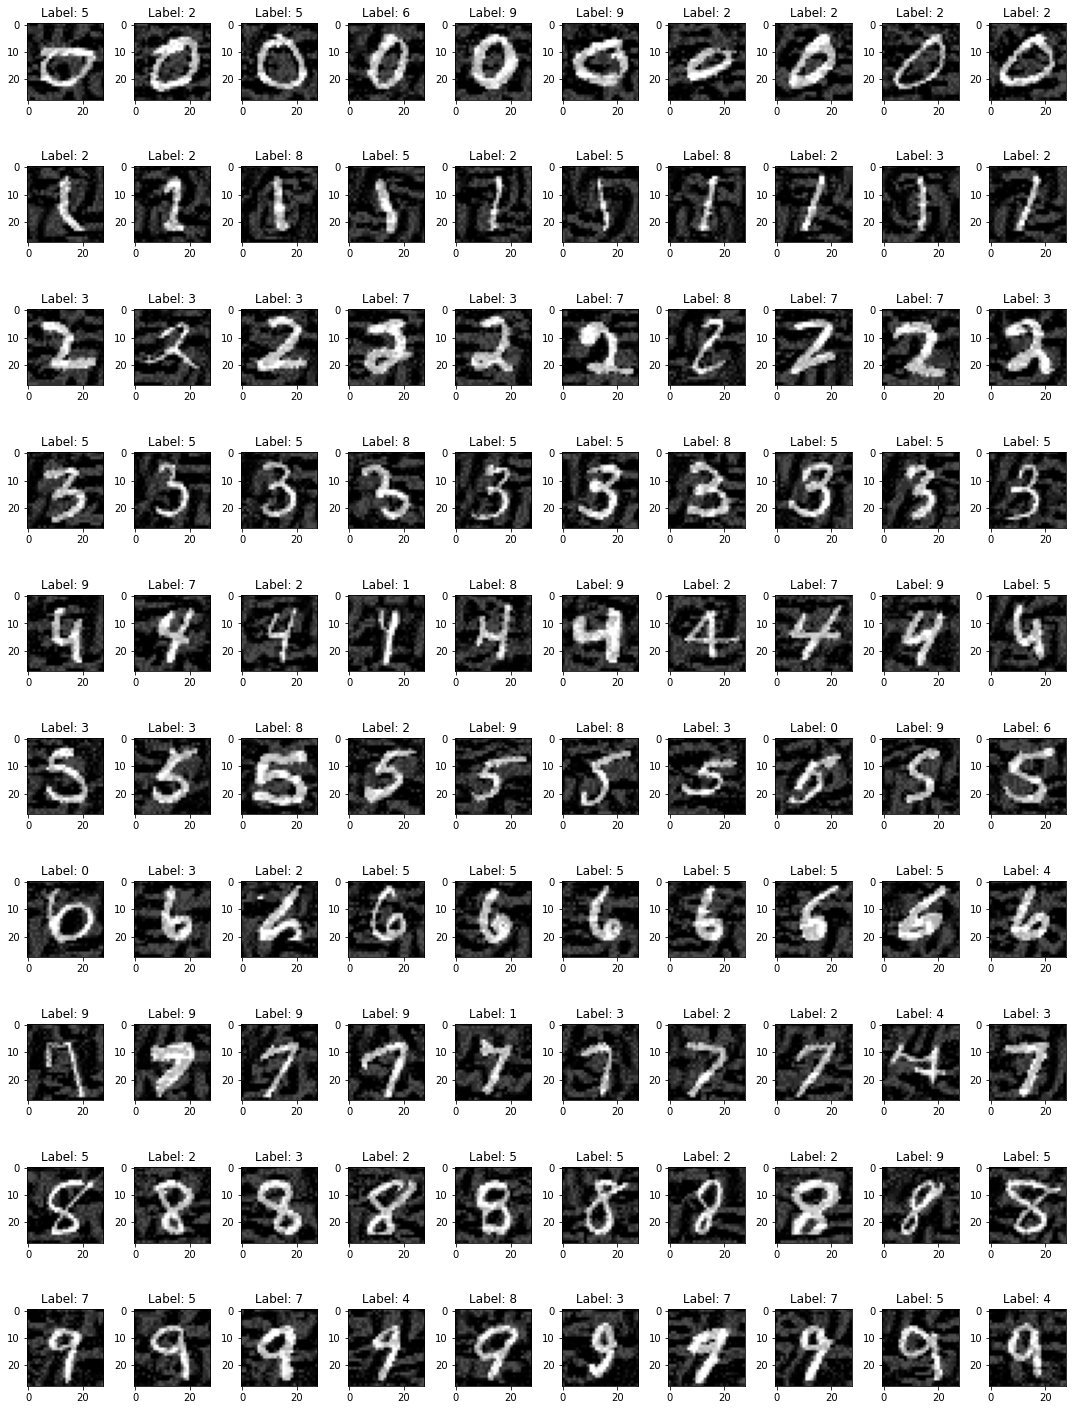

In [25]:
plot_image_grid(nb_classes, samples_per_class, image_samples_adv.numpy(), label_sample_adv, (28, 28))

In [26]:
y_adv = []
y_true = []
for X_batch, y_batch in mnist_test:
    X_batch_adv = pgd_attack(lenet, X_batch, y_batch, 0.3, 20, 0.01, 0.0, 1.0, soft_label=False)
    y_batch_adv = np.argmax(lenet(X_batch_adv).numpy(), 1)
    y_adv.append(y_batch_adv[0].tolist())
    y_true.append(y_batch.numpy()[0].tolist())

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
test_adv_acc = accuracy_score(y_true, y_adv)
print("Test adv accuracy:{}".format(test_adv_acc))

Test adv accuracy:0.012738853503184714


We run another attack using MIM.

In [29]:
image_samples_adv = mim_attack(lenet, image_samples, label_samples, 0.3, 0.9, 20, 0.01, 0.0, 1.0)
label_sample_adv = np.argmax(lenet(image_samples_adv).numpy(), 1)

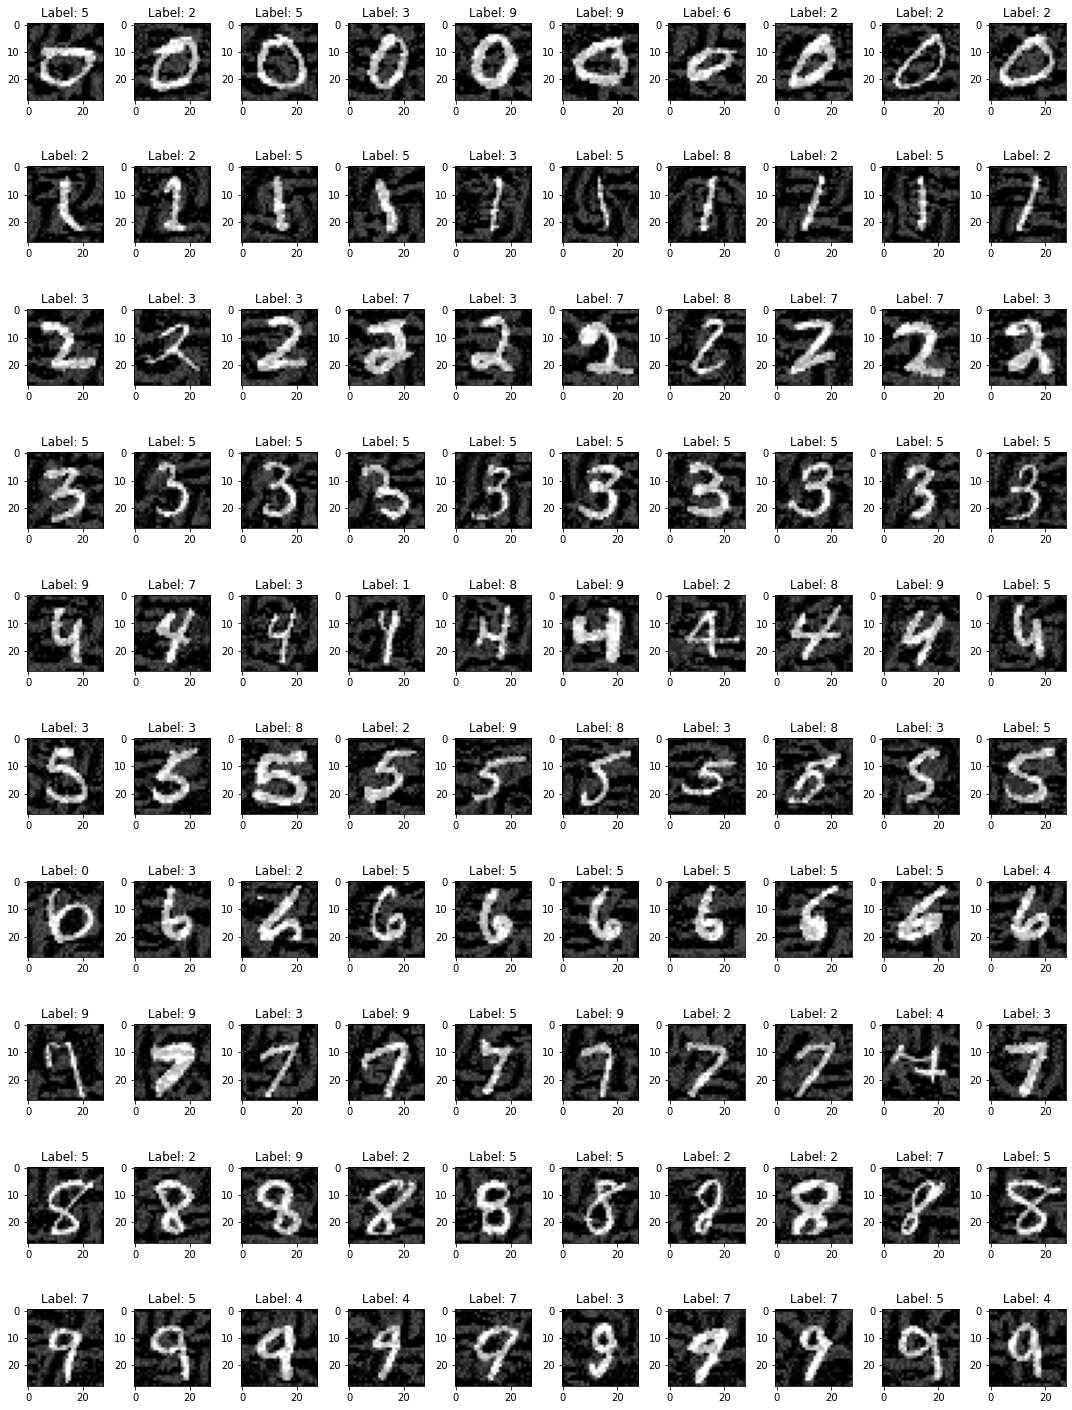

In [30]:
plot_image_grid(nb_classes, samples_per_class, image_samples_adv.numpy(), label_sample_adv, (28, 28))

### <span style="color:#0b486b">III.4 Attack LeNet trained on MNIST with Adversarial Learning</span> ###

In [31]:
lenet_defence = le_net()

In [32]:
optimizer = tf.optimizers.Adam(learning_rate=0.001)
loss_obj = tf.nn.sparse_softmax_cross_entropy_with_logits

# metrics to track the different accuracies.
train_loss = tf.metrics.Mean(name='train_loss')
test_acc_clean = tf.metrics.SparseCategoricalAccuracy()
test_acc_pgd = tf.metrics.SparseCategoricalAccuracy()

In [33]:
def train_step_adv(x, x_adv, y):
    with tf.GradientTape() as tape:
        logits = lenet_defence(x)
        logits_adv = lenet_defence(x_adv)
        loss = (loss_obj(y, logits) + loss_obj(y, logits_adv))/2
        gradients = tape.gradient(loss, lenet_defence.trainable_variables)
        optimizer.apply_gradients(zip(gradients, lenet_defence.trainable_variables))
    return loss

We reinforce the defence model by adversarial examples which are generated by pgd_attack with lower capacity (e.g., num_steps=10) 

In [34]:
epochs = 5 # number of epochs
for epoch in range(epochs):
    # keras like display of progress
    progress_bar_train = tf.keras.utils.Progbar(60000, verbose=2)
    for (x, y) in mnist_train:
       # replace clean example with adversarial example by 10-steps projected_gradient_descent for adversarial training
        x_adv = pgd_attack(lenet_defence, x, y, 0.3, 10, 0.01, 0.0, 1.0)
        loss = train_step_adv(x, x_adv, y)
        y_pred = lenet_defence(x)
        test_acc_clean(y, y_pred)
        train_loss(loss)
        progress_bar_train.add(x.shape[0], values=[('loss', train_loss.result()), ("acc (%)", test_acc_clean.result() * 100)])

60000/60000 - 156s - loss: 0.8524 - acc (%): 82.2733
60000/60000 - 158s - loss: 0.3804 - acc (%): 94.2417
60000/60000 - 158s - loss: 0.2899 - acc (%): 95.9317
60000/60000 - 157s - loss: 0.2431 - acc (%): 96.7581
60000/60000 - 159s - loss: 0.2134 - acc (%): 97.2542


We then evaluate the defence model with the same pgd_attack but higher attack capacity (e.g., num_steps=20)

In [35]:
y_adv = []
y_true = []
for X_batch, y_batch in mnist_test:
    X_batch_adv =x_adv = pgd_attack(lenet_defence, X_batch, y_batch, 0.3, 20, 0.01, 0.0, 1.0)
    y_batch_adv = np.argmax(lenet_defence(X_batch_adv).numpy(), 1)
    y_adv.append(y_batch_adv[0].tolist())
    y_true.append(y_batch.numpy()[0].tolist())

In [36]:
test_adv_acc = accuracy_score(y_true, y_adv)
print("Test adv accuracy:{}".format(test_adv_acc))

Test adv accuracy:0.8471337579617835


In [37]:
image_samples_adv = pgd_attack(lenet_defence, image_samples, label_samples, 0.3, 20, 0.01, 0.0, 1.0)
label_sample_adv = np.argmax(lenet(image_samples_adv).numpy(), 1)

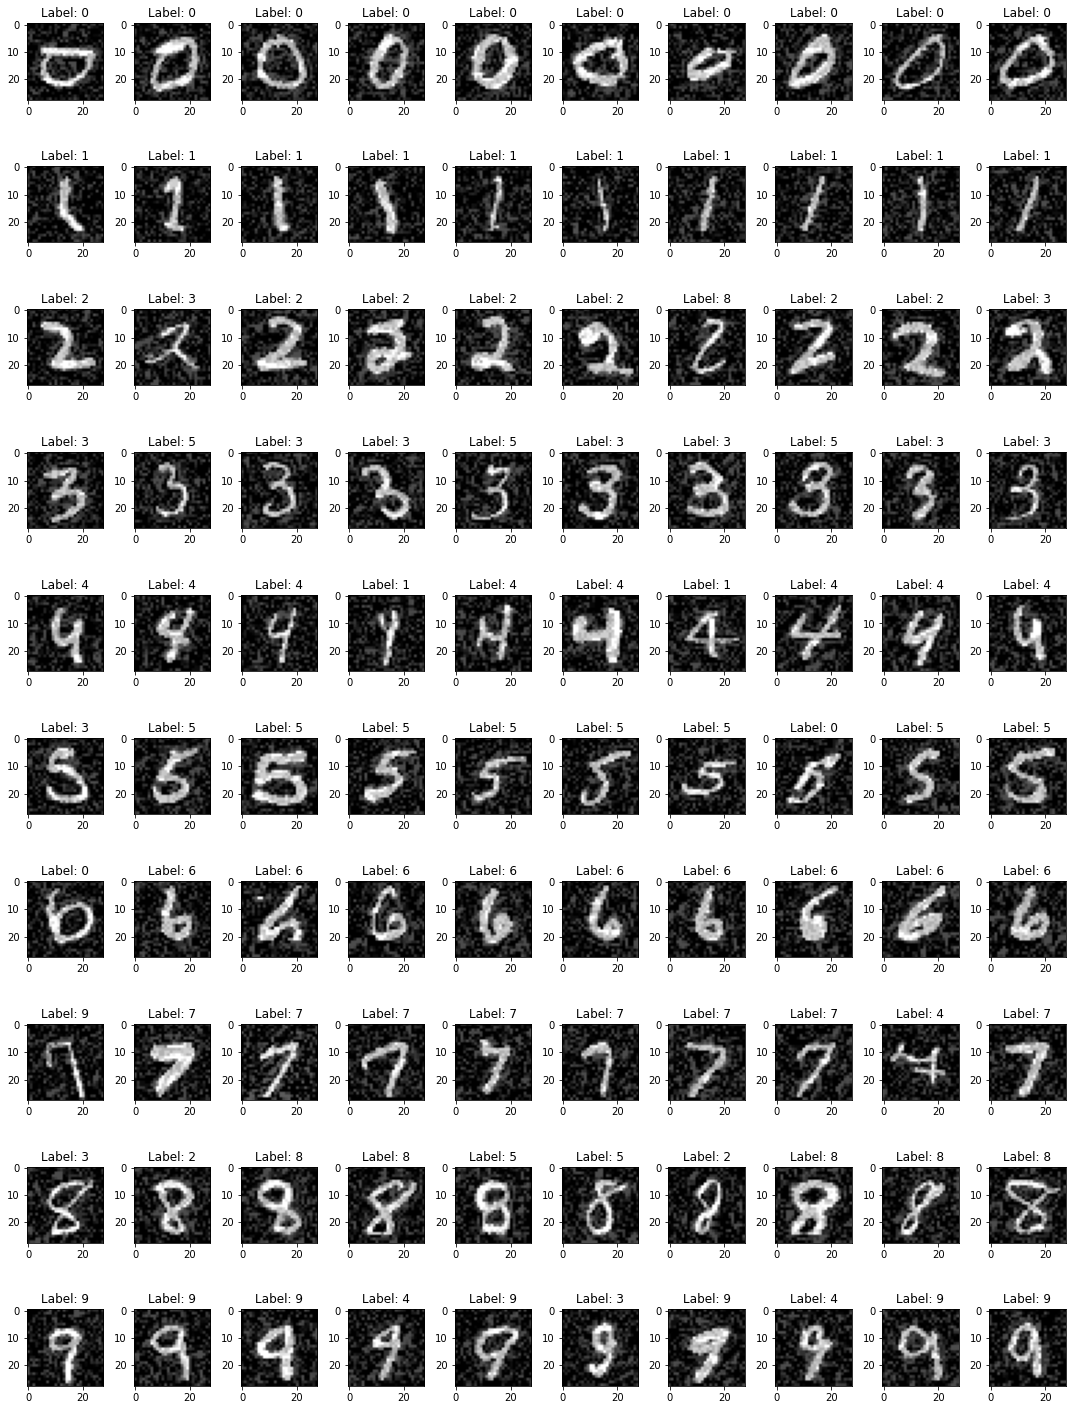

In [38]:
plot_image_grid(nb_classes, samples_per_class, image_samples_adv.numpy(), label_sample_adv, (28, 28))

---
### <span style="color:#0b486b"> <div  style="text-align:center">**THE END**</div> </span>